In [ ]:
# Notebook constants (for static analysis and quick reruns)
from pathlib import Path
DATA_DIR = Path(r"C:\Users\mommy\Documents\market-recognition\dataset")
TRAIN_DIR = DATA_DIR / 'train'
OUTPUT_DIR = Path(r"C:\Users\mommy\Documents\market-recognition\model\run_10epochs")
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 5
LEARNING_RATE = 1e-3
FINE_TUNE = False

print('Constants:')
print(' DATA_DIR =', DATA_DIR)
print(' OUTPUT_DIR =', OUTPUT_DIR)

# Fresh Evaluation Notebook
This notebook provides a clean, reproducible evaluation workflow for the current trained model: readiness checks, full test-set evaluation, optional ROC/AUC computation, a quick single-image test, and a documentation template. Run cells incrementally.

In [2]:
#Paths and knobs
from pathlib import Path

# Use absolute workspace paths provided by the user
DATA_DIR = Path(r"C:\Users\mommy\Documents\market-recognition\dataset")
TRAIN_DIR = str(DATA_DIR / 'train')
# point OUTPUT_DIR to the specific run that contains the saved model artifacts
OUTPUT_DIR = str(Path(r"C:\Users\mommy\Documents\market-recognition\model\run_10epochs"))
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 5
LEARNING_RATE = 1e-3
FINE_TUNE = False

print('DATA_DIR =', DATA_DIR)
print('TRAIN_DIR =', TRAIN_DIR)
print('OUTPUT_DIR =', OUTPUT_DIR)


DATA_DIR = C:\Users\mommy\Documents\market-recognition\dataset
TRAIN_DIR = C:\Users\mommy\Documents\market-recognition\dataset\train
OUTPUT_DIR = C:\Users\mommy\Documents\market-recognition\model\run_10epochs


In [4]:
# GPU / TF check
import tensorflow as tf

# Use getattr to access `config` to avoid static-analysis warnings from Pylance
tf_config = getattr(tf, 'config', None)
if tf_config is not None:
    gpus = tf_config.list_physical_devices('GPU')
    if gpus:
        print('GPUs detected:')
        for g in gpus:
            print('-', g)
    else:
        print('No GPU detected; training/eval will run on CPU.')
else:
    # Fallback message when the `config` attribute isn't exposed in stubs/build
    print('TensorFlow `config` API not detected; running on CPU (or TF build without config exposure).')


No GPU detected; training/eval will run on CPU.


In [ ]:
#Readiness check for evaluation
from pathlib import Path
import json

MODEL_PATH = Path(OUTPUT_DIR) / "product_classifier.keras"
LABELS = Path(OUTPUT_DIR) / "labels.txt"

#Candidate test directories (prefer dataset in repo)
REPO_ROOT = Path('.').resolve()
CANDIDATES = [REPO_ROOT / 'dataset' / 'test', Path(TRAIN_DIR).parent / 'test', REPO_ROOT / 'test']
TEST_DIR = next((p for p in CANDIDATES if p.exists()), CANDIDATES[0])

print('Model path:', MODEL_PATH)
print('Model exists:', MODEL_PATH.exists())
print('Labels file exists:', LABELS.exists())
print('Selected test dir:', TEST_DIR)
print('Test dir exists:', TEST_DIR.exists())

readiness = {
    'model_exists': MODEL_PATH.exists(),
    'labels_exists': LABELS.exists(),
    'test_dir': str(TEST_DIR),
    'test_dir_exists': TEST_DIR.exists(),
}

# Save readiness summary
out = Path(OUTPUT_DIR)
out.mkdir(parents=True, exist_ok=True)
(out / 'readiness.json').write_text(json.dumps(readiness, indent=2))
print('\nWrote readiness.json to', out / 'readiness.json')


Model path: C:\Users\mommy\Documents\market-recognition\model\run_10epochs\product_classifier.keras
Model exists: True
Labels file exists: True
Selected test dir: C:\Users\mommy\Documents\market-recognition\dataset\test
Test dir exists: True

Wrote readiness.json to C:\Users\mommy\Documents\market-recognition\model\run_10epochs\readiness.json


In [1]:
# Install missing packages for evaluation (matplotlib, seaborn, scikit-learn, Pillow)
import sys
import subprocess
pkgs = ['matplotlib','seaborn','scikit-learn','Pillow']
try:
    import matplotlib
    import seaborn
    import sklearn
except Exception:
    print('Installing packages:', pkgs)
    subprocess.check_call([sys.executable, '-m', 'pip', 'install'] + pkgs)
    print('Installed packages')


Loading model...


c:\Users\mommy\miniconda3\envs\marketrec\Lib\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 6 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Found 2713 images belonging to 39 classes.
Predicting on test set...
85/85 ━━━━━━━━━━━━━━━━━━━━ 103s 1s/step


c:\Users\mommy\miniconda3\envs\marketrec\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 4768 (\N{ETHIOPIC SYLLABLE GLOTTAL A}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
c:\Users\mommy\miniconda3\envs\marketrec\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 4867 (\N{ETHIOPIC SYLLABLE JAA}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
c:\Users\mommy\miniconda3\envs\marketrec\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 4619 (\N{ETHIOPIC SYLLABLE LAA}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
c:\Users\mommy\miniconda3\envs\marketrec\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 4845 (\N{ETHIOPIC SYLLABLE YE}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
c:\Users\mommy\miniconda3\envs\marketrec\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 4941 (\N{ETHIOPIC SYLLABLE FE}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
c:\Users\mommy\miniconda3\envs\marketrec\Lib\site-packages\seaborn

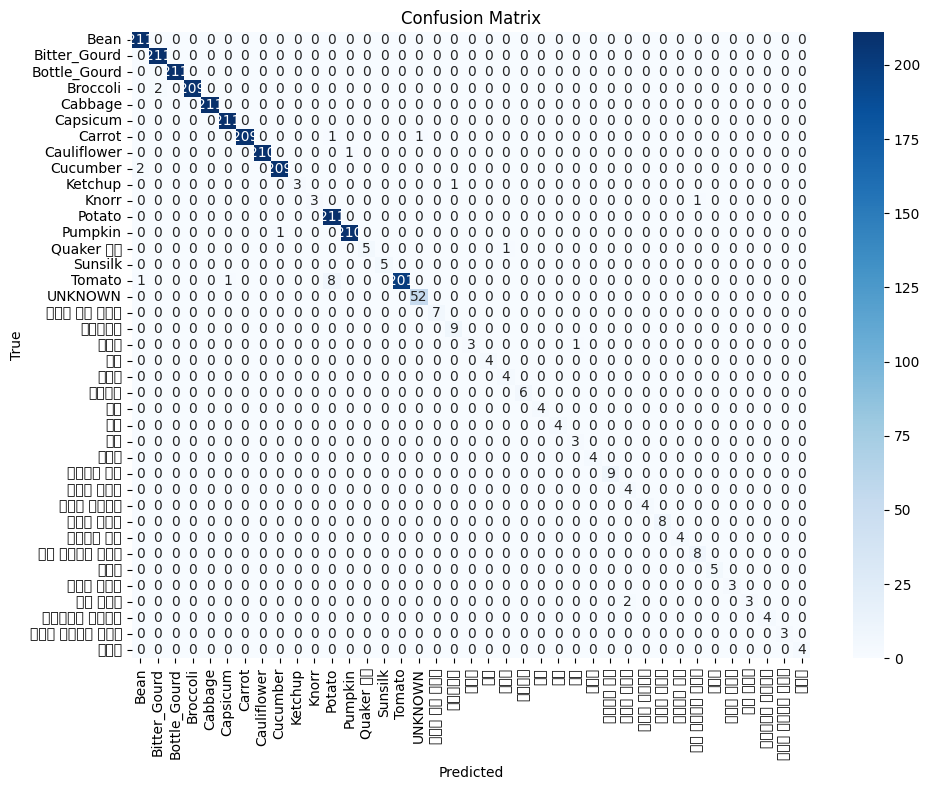

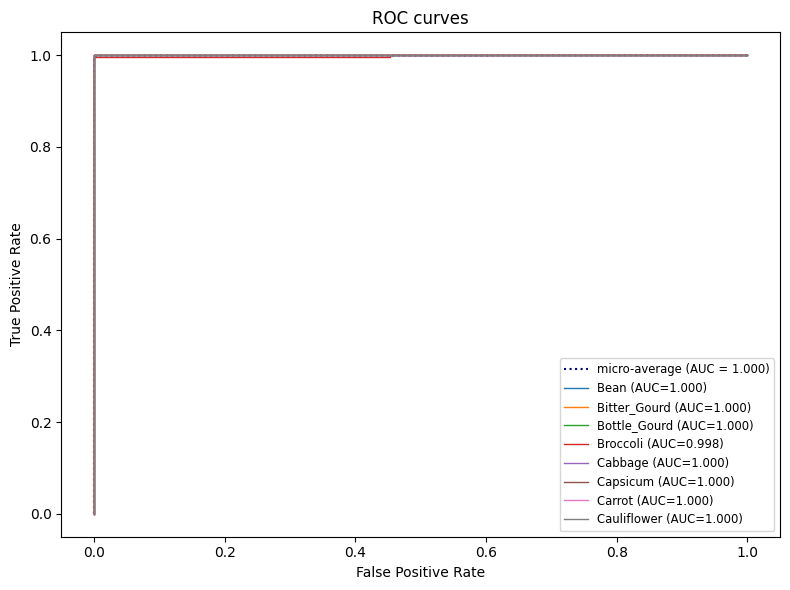

Wrote evaluation outputs to C:\Users\mommy\Documents\market-recognition\model\run_10epochs


In [6]:
# Full test-set evaluation (disabled by default)
# Set RUN_FULL_EVAL = True to run. This cell will:
# - Load the saved model
# - Run predictions on a `test` directory (one subfolder per class)
# - Save a JSON classification report, confusion matrix image, optional ROC curves, and sample predictions

RUN_FULL_EVAL = True

if RUN_FULL_EVAL:
    import json
    from pathlib import Path
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    from tensorflow.keras.preprocessing.image import ImageDataGenerator
    import sklearn.metrics as metrics
    from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc  # type: ignore[attr-defined]
    from sklearn.preprocessing import label_binarize

    MODEL_PATH = Path(OUTPUT_DIR) / "product_classifier.keras"
    MODEL_PATH = Path(OUTPUT_DIR) / "product_classifier.keras"
    LABELS_PATH = Path(OUTPUT_DIR) / "labels.txt"
    OUT = Path(OUTPUT_DIR)
    OUT.mkdir(parents=True, exist_ok=True)

    if not MODEL_PATH.exists():
        raise FileNotFoundError(f"Model not found at {MODEL_PATH}")
    if not LABELS_PATH.exists():
        raise FileNotFoundError(f"labels.txt not found at {LABELS_PATH}")

    # Determine test dir
    CANDIDATES = [Path('./dataset/test'), Path(TRAIN_DIR).parent / 'test']
    TEST_DIR = next((p for p in CANDIDATES if p.exists()), CANDIDATES[0])
    if not TEST_DIR.exists():
        raise FileNotFoundError(f"Test directory not found. Searched: {CANDIDATES}")

    print('Loading model...')
    model = tf.keras.models.load_model(MODEL_PATH)

    datagen = ImageDataGenerator(rescale=1.0/255)
    test_gen = datagen.flow_from_directory(
        TEST_DIR,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        shuffle=False,
    )

    print('Predicting on test set...')
    probs = model.predict(test_gen, verbose=1)
    preds = probs.argmax(axis=1)
    truths = test_gen.classes

    labels = [None] * len(test_gen.class_indices)
    for k, v in test_gen.class_indices.items():
        labels[v] = k
    # Ensure labels are strings (no None) for plotting functions
    labels = [str(x) if x is not None else '' for x in labels]

    # Classification report
    report = classification_report(truths, preds, target_names=labels, output_dict=True)

    # Confusion matrix
    cm = confusion_matrix(truths, preds)

    # Top-k accuracy
    def top_k_accuracy(probs, truths, k=5):
        topk = np.argsort(probs, axis=1)[:, ::-1][:, :k]
        hits = [1 if truths[i] in topk[i] else 0 for i in range(len(truths))]
        return float(np.mean(hits))

    top1 = top_k_accuracy(probs, truths, k=1)
    top5 = top_k_accuracy(probs, truths, k=min(5, probs.shape[1]))

    summary = {
        'num_samples': int(test_gen.samples),
        'num_classes': int(test_gen.num_classes),
        'accuracy_top1': float(top1),
        'accuracy_top5': float(top5),
    }

    # Save results
    (OUT / 'eval_report.json').write_text(json.dumps({'summary': summary, 'report': report}, indent=2))
    np.save(OUT / 'confusion.npy', cm)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')  # type: ignore[arg-type]
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.savefig(OUT / 'confusion_matrix.png', dpi=150)
    plt.show()

    # ROC / AUC (multiclass) - optional
    try:
        # Ensure label_binarize returns a dense NumPy array (avoid sparse matrix issues)
        y_true_bin = np.asarray(label_binarize(truths, classes=range(len(labels))))
        n_classes = y_true_bin.shape[1]
        fpr = dict(); tpr = dict(); roc_auc = dict()
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], probs[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
        # micro-average
        fpr['micro'], tpr['micro'], _ = roc_curve(np.ravel(y_true_bin), np.ravel(probs))
        roc_auc['micro'] = auc(fpr['micro'], tpr['micro'])

        # plot subset of curves
        plt.figure(figsize=(8,6))
        plt.plot(fpr['micro'], tpr['micro'], label=f"micro-average (AUC = {roc_auc['micro']:.3f})", color='navy', linestyle=':')
        for i in range(min(8, n_classes)):
            plt.plot(fpr[i], tpr[i], lw=1, label=f"{labels[i]} (AUC={roc_auc[i]:.3f})")
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC curves')
        plt.legend(loc='lower right', fontsize='small')
        plt.tight_layout()
        plt.savefig(OUT / 'roc_curves.png', dpi=150)
        plt.show()

        auc_out = {labels[i]: float(roc_auc[i]) for i in range(n_classes)}
        auc_out['micro'] = float(roc_auc['micro'])
        (OUT / 'auc_report.json').write_text(json.dumps(auc_out, indent=2))
    except Exception as e:
        print('Skipping ROC/AUC computation:', e)

    # Save a few sample images with predicted/actual in filename
    samples_out = OUT / 'samples'
    samples_out.mkdir(exist_ok=True)
    N = min(40, test_gen.samples)
    for i in range(N):
        src = Path(TEST_DIR) / test_gen.filenames[i]
        pred_label = labels[int(preds[i])]
        true_label = labels[int(truths[i])]
        dst = samples_out / f"{i:03d}__pred_{pred_label}__true_{true_label}__{src.name}"
        try:
            import shutil
            shutil.copy(src, dst)
        except Exception:
            pass

    print('Wrote evaluation outputs to', OUT)
else:
    print('RUN_FULL_EVAL is False — set to True to run a full test-set evaluation.')

## Documentation Template

Use this template to describe your run results (Project, Dataset, Model, Training, Evaluation, Testing, Conclusion). Fill in metrics and attach `model/eval_report.json`, `model/confusion_matrix.png`, and `model/roc_curves.png` if produced.

In [10]:
# Quick single-image test
from tensorflow.keras.preprocessing import image
from pathlib import Path

REPO_ROOT = Path(r"C:\Users\mommy\Documents\market-recognition")
SAMPLE_PATH = REPO_ROOT / 'dataset' / 'train' / 'bean' / '0001.jpg'  # change to any local file
labels_path = Path(OUTPUT_DIR) / "labels.txt"
model_path = Path(OUTPUT_DIR) / "product_classifier.keras"

if not SAMPLE_PATH.is_file():
    print("Update SAMPLE_PATH to point to a real image.")
elif not labels_path.is_file():
    print("labels.txt not found; train the model first.")
elif not model_path.exists():
    print("Saved model missing; train before testing.")
else:
    labels = labels_path.read_text(encoding="utf-8").splitlines()
    model = tf.keras.models.load_model(model_path)
    img = image.load_img(str(SAMPLE_PATH), target_size=IMG_SIZE)
    arr = image.img_to_array(img) / 255.0
    probs = model.predict(arr[None, ...])[0]
    idx = int(probs.argmax())
    print(f"Predicted: {labels[idx]} (p={probs[idx]:.3f})")


c:\Users\mommy\miniconda3\envs\marketrec\Lib\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 6 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicted: Bean (p=1.000)
